<div style="background-color: #004B87; padding: 20px; text-align: center; border-radius: 10px; color: white; font-family: Arial, sans-serif; margin: auto; width: 80%;">
    <h1>Module 3 Assignment</h1>
    <h2>RURANGWA IRADUKUNDA Jean-François Régis</h2>
    <h3>September 7, 2025</h3>
    <p>Email : jeanfrancoisregis.rurangwairadukunda@axa.be</p>
</div>

# Introduction


Following the 'Actuarial Data Scientist' program offered by the Belgian association of actuaries (IABE), we are assessed an assignment that builds on the foundational concepts learned in the third and last module.
<br/>
This assignment involves analyzing the "eusavingULnoPS" dataset which is based on unit-linked saving products, with no profit sharing, sold in an unknown European country. Those insurance policies are observed between 1999 and 2008, with entries and exits possible.
<br/>

In this analysis, we will focus on developing classification and regression models for specific targets, applying feature selection techniques, and implementing explainability and fairness assessments.
<br/>
The objective is to provide actionable insights into the factors influencing policy lapses and risk premium proportions, ensuring the models are transparent, fair, and robust.

## Importing packages <a name="Importing_packages"></a>

Our first step is to import and load the packages that will be necessary in our task.


In [48]:
from ipywidgets import Widget
Widget.widgets = {}  # Reset all widget states

In [ ]:
## Perform these pip installs in the command prompt, with your python kernel activated
!pip install shap
!pip install tensorflow
!pip install shapicant
!pip install scikeras
!pip install mlflow
!pip install evidently
!pip install boruta
!pip install pandas scikit-learn deap
!pip install aif360

!git clone https://github.com/Regis0323/Module-3-assignment.git
!pip install scikit-fuzzy

In [ ]:
# 1. SETUP: load libraries & data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data preprocesing and models
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LassoCV, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report

# MLFlow
import mlflow
import cloudpickle
from evidently import Dataset
from evidently import DataDefinition
from evidently import Report
from evidently.presets import DataDriftPreset, DataSummaryPreset

# Feature selection and explainability of the model
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from boruta import BorutaPy
from deap import base, creator, tools, algorithms
import random

# Bias mitigation
from aif360.datasets import StandardDataset, BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools
from aif360.algorithms.preprocessing import Reweighing, OptimPreproc
from aif360.algorithms.inprocessing import MetaFairClassifier, AdversarialDebiasing
from aif360.algorithms.postprocessing import RejectOptionClassification, EqOddsPostprocessing



# Data exploration and preoprocessing


Then we load the dataset and get its specificities.

In [ ]:
# Load
df = pd.read_csv("/content/Module-3-assignment/eusavingULnoPS.csv")
display(df.head())
print(df.dtypes.value_counts())

,policy.ID,issue.date,termination.date,lapse.reason,premium.frequency,gender,underwriting.age,face.amount,risk.premium,saving.premium,...,rate2Y.relvar1mth,rate2Y.relvar1qtr,rate10Y.relvar1mth,rate10Y.relvar1qtr,unemploy.relvar1mth,unemploy.relvar1qtr,industry.relvar1mth,industry.relvar1qtr,RTV.relvar1mth,RTV.relvar1qtr
0,N1,1999-01-01,2006-04-01,Claim,unique,Male,77,2979.53,265.86,29795.27,...,0.086310,0.184211,0.081598,0.144626,-0.011494,-0.011494,-0.000979,0.016699,0.005941,0.006931
1,N2,1999-01-01,2006-04-01,Claim,unique,Male,77,3039.71,271.23,30397.16,...,0.086310,0.184211,0.081598,0.144626,-0.011494,-0.011494,-0.000979,0.016699,0.005941,0.006931
2,N3,1999-01-01,2005-04-01,Surrender,unique,Female,72,2994.12,80.43,35929.44,...,-0.025391,-0.018489,-0.023343,-0.018868,-0.010309,-0.040816,0.001000,0.003024,0.002002,0.000998
3,N4,1999-01-01,2003-02-01,Surrender,unique,Male,35,3051.10,7.50,30511.01,...,-0.041762,-0.133838,-0.038309,-0.039273,0.000000,-0.008850,-0.003067,0.000000,0.009524,0.009574
4,N5,1999-01-01,2008-01-01,In force,unique,Male,40,5810.21,81.39,58102.11,...,0.037712,-0.004430,0.025938,-0.002027,0.022727,0.069767,0.001876,0.000941,-0.011550,-0.026692


float64    23
object      6
int64       1
Name: count, dtype: int64


Our dataset is composed of 30 columns, of which 6 are categorized as 'object', 1 as 64-bit 'integer' (int64) and 23 as 64-bit 'floating-point' (float64) numbers.
<br>
We shall now check for missing and/or duplicated values before treating them accordingly if any.

In [ ]:
#Potential missing values
Missing_Values=df.isna().sum()
print(Missing_Values)

#Potential duplicated values
Duplicated_Values=df[df.duplicated(keep=False)]
print(Duplicated_Values)
  #Treating duplicated values (if any)
df_cleaned=df.drop_duplicates(keep='first')

#Information about the new cleaned dataset
df_cleaned.info()
print(df_cleaned.columns.tolist())

policy.ID              0
issue.date             0
termination.date       0
lapse.reason           0
premium.frequency      0
gender                 0
underwriting.age       0
face.amount            0
risk.premium           0
saving.premium         0
CPI.relvar1mth         0
CPI.relvar1qtr         0
CPI.relvar1yr          0
CPI.relvar2yr          0
EUidx.relvar1mth       0
EUidx.relvar1qtr       0
EUidx.relvar1yr        0
EUidx.relvar2yr        0
rate1Y.relvar1mth      0
rate1Y.relvar1qtr      0
rate2Y.relvar1mth      0
rate2Y.relvar1qtr      0
rate10Y.relvar1mth     0
rate10Y.relvar1qtr     0
unemploy.relvar1mth    0
unemploy.relvar1qtr    0
industry.relvar1mth    0
industry.relvar1qtr    0
RTV.relvar1mth         0
RTV.relvar1qtr         0
dtype: int64
Empty DataFrame
Columns: [policy.ID, issue.date, termination.date, lapse.reason, premium.frequency, gender, underwriting.age, face.amount, risk.premium, saving.premium, CPI.relvar1mth, CPI.relvar1qtr, CPI.relvar1yr, CPI.relvar2yr, EUidx.

After this check, we can see that there are neither missing values nor duplicates and there are 2 date variables that have been properly treated.

We shall now create two datasets (df_cat and df_num), one for each of the following two dependent variables:
*   a categorical one: lapse.reason;
*   a numeric one: a numerical variable that represents the proportion of risk premium over total premium: proportion_risk_premium = risk.premium / (risk.premium+saving.premium)

In [ ]:
# Conversion of the date columns from 'object' to 'datetime'
df_cleaned['issue.date'] = pd.to_datetime(df['issue.date'], errors='coerce')
df_cleaned['termination.date'] = pd.to_datetime(df['termination.date'], errors='coerce')

# Creation of numerical and categorical datasets
df_cat = df_cleaned.copy()
df_num = df_cleaned.copy()

# Creation of numerical dependent variable
df_num['proportion_risk_premium'] = df_num['risk.premium']/(df_num['risk.premium'] + df_num['saving.premium'])

## Data preprocessing
After creating the numerical and categorical datasets, we shall now define the X (X_cat and X_num) and y datasets before converting categorical variables to a suitable format (using the "one-hot encoding" method), handling date variables and splitting the datasets into training and test sets.

In [ ]:
# Definition of X and y datasets
y_num = df_num['proportion_risk_premium']
y_cat = df_cat['lapse.reason']
X_num = df_num.drop(['proportion_risk_premium'], axis=1)
X_cat = df_cat.drop(['lapse.reason'], axis=1)

# One-hot encoding method for categorical variables
categorical_cols = X_cat.select_dtypes(include=['object']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough')

# Date variables handling
for df_ in [X_num, X_cat]:
    df_['issue_date_year'] = df_['issue.date'].dt.year
    df_['issue_date_month'] = df_['issue.date'].dt.month
    df_['termination_date_year'] = df_['termination.date'].dt.year
    df_['termination_date_month'] = df_['termination.date'].dt.month
    df_.drop(['issue.date', 'termination.date'], axis=1, inplace=True)

# Split test and train datasets
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, test_size=0.25, random_state=23, stratify=y_cat)

X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(X_num, y_num, test_size=0.25, random_state=23)

## Development of model for categorical variable: RandomForest

In this part we shall develop a Random Forest algorithm for the categorical dependent variable "lapse.reason".

In [ ]:
# Building the pipeline with preprocessing and classifier
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=23))
])

# Fitting the model on training data
rf_pipeline.fit(X_train_cat, y_train_cat)

# Predicting on test data
y_pred = rf_pipeline.predict(X_test_cat)

# Evaluating the model
print("Classification report for 'lapse.reason':")
print(classification_report(y_test_cat, y_pred))

Classification report for 'lapse.reason':
              precision    recall  f1-score   support

       Claim       1.00      0.10      0.19        49
    In force       1.00      1.00      1.00      3470
   Surrender       0.98      1.00      0.99      1962

    accuracy                           0.99      5481
   macro avg       0.99      0.70      0.72      5481
weighted avg       0.99      0.99      0.99      5481



These results show us that the current model is performing well overall (very high/perfect precision), but poorly on the minority class especially on the claim with a very small recall and we shall tune the model now to see if we can improve it.

In [ ]:
param_dist = {
    'classifier__n_estimators': [10, 30, 50],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt','log2']
}

# Setting up RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf_pipeline, param_distributions=param_dist,
    n_iter=20, scoring='f1_weighted', cv=5, n_jobs=-1, verbose=2, random_state=23
)

# Running hyperparameter tuning
random_search.fit(X_train_cat, y_train_cat)

# Best parameters
print("Best hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'classifier__n_estimators': 30, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'log2', 'classifier__max_depth': None}


In [ ]:
# Building the pipeline with the best hyperparameters
clf_best = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=30,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='log2',
        max_depth=None,
        random_state=23
    ))
])

# Training the classifier
clf_best.fit(X_train_cat, y_train_cat)

# Predicting on test set
y_pred = clf_best.predict(X_test_cat)

# Generating classification report
print("Classification Report with best hyperparameters:")
print(classification_report(y_test_cat, y_pred))


Classification Report with best hyperparameters:
              precision    recall  f1-score   support

       Claim       1.00      0.12      0.22        49
    In force       1.00      1.00      1.00      3470
   Surrender       0.98      1.00      0.99      1962

    accuracy                           0.99      5481
   macro avg       0.99      0.71      0.74      5481
weighted avg       0.99      0.99      0.99      5481



After the hyperparameter tuning, we observe that the high overall accuracy is still driven mainly by majority classes, the model is still perfoming well and there is a small improvement in the Claim recall (from 10% to 12%), which shows that the model still struggles to detect claims effectively.

## Development of model for numerical variable (proportion): Sequential Dense NN


In this section we shall develop a Sequential Dense Neural Network for the numerical variable "proportion_risk_premium".

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0801e-05 - mae: 0.0037
Test MAE: 0.0036078321281820536


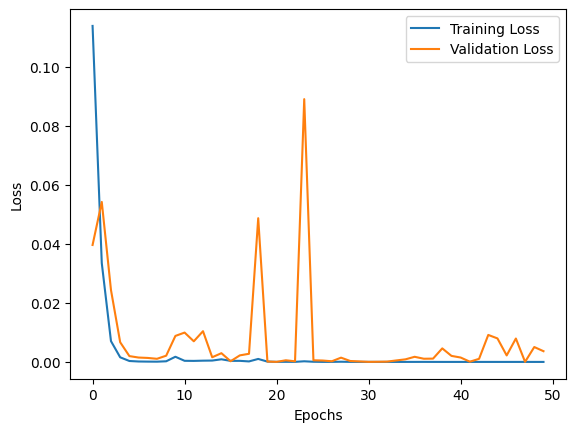

In [ ]:
# Setting seeds for reproducibility
seed_value = 23
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# One-hot encoding method for categorical variables
categorical_cols_num = X_train_num.select_dtypes(include=['object']).columns.tolist()
preprocessor_num = ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_num)],
    remainder='passthrough')

# Fitting and transforming the training and testing datasets
X_train_encoded_num = preprocessor_num.fit_transform(X_train_num)
X_test_encoded_num = preprocessor_num.transform(X_test_num)

X_train_dense_num = X_train_encoded_num.toarray() if hasattr(X_train_encoded_num, "toarray") else X_train_encoded_num
X_test_dense_num = X_test_encoded_num.toarray() if hasattr(X_test_encoded_num, "toarray") else X_test_encoded_num

# Scaling all features
scaler = StandardScaler()
X_train_scaled_num = scaler.fit_transform(X_train_dense_num)
X_test_scaled_num = scaler.transform(X_test_dense_num)

# Defining the neural network
nn_model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled_num.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear')
])

# Model compilation
nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Model training
history = nn_model.fit(
    X_train_scaled_num,
    y_train_num,
    validation_split=0.25,
    epochs=50,
    batch_size=32,
    verbose=0
)

# Model evaluation
loss, mae = nn_model.evaluate(X_test_scaled_num, y_test_num)
print(f"Test MAE: {mae}")

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


From the results above we can say that, with the average absolute error (MAE) in predicting "proportion_risk_premium" of 0.36%, the model is highly accurate at estimating the target variable on unseen data and that the model has effectively learned the relationship between features and the "proportion_risk_premium".

# Variable selection

## Categorical problem, feature selection

In this section, we shall perform Boruta feature selection, using (from boruta) BortutaPy, for the categorical dependent variable "lapse.reason".

In [ ]:
# Fit the preprocessor on training data
preprocessor.fit(X_train_cat)

# Transform train and test features
X_train_encoded = preprocessor.transform(X_train_cat)
X_test_encoded = preprocessor.transform(X_test_cat)

# Convert to dense numpy arrays
X_train_dense = X_train_encoded if hasattr(X_train_encoded, "toarray") else X_train_encoded
X_test_dense = X_test_encoded if hasattr(X_test_encoded, "toarray") else X_test_encoded

if hasattr(X_train_dense, "toarray"):
    X_train_dense = X_train_dense.toarray()
if hasattr(X_test_dense, "toarray"):
    X_test_dense = X_test_dense.toarray()


In [ ]:
# Now fit Boruta
rf = RandomForestClassifier(n_estimators=10, random_state=23)
selector = BorutaPy(rf, max_iter=5, random_state=23, verbose=0)
selector.fit(X_train_dense, y_train_cat.values)

# Getting feature names after encoding
feature_names = np.array(preprocessor.get_feature_names_out())
selected_features = feature_names[selector.support_]

print("Boruta selected features:")
print(list(selected_features))

Boruta selected features:
[]


Unfortunately, for the boruta feature selection we were not able to get feature selections after 25 minuts of run due to the hugeness of the data; i.e, for us to get more precise information, we would need to use more estimators (50 or 100) and increase the maximum number of iterations (20 or more) but doing this makes our program crash due to lack of RAM.

Now we shall perform Genetic Algorithm feature selection using (from deap) base, creator, tools, algorithms respectively for the categorical dependent variable "lapse.reason".

In [ ]:
# Defining the fitness evaluation function
feature_names_GA = preprocessor.get_feature_names_out()
def evalFitness(individual):
    if sum(individual) == 0:
        return 0.,
    selected_indices = [i for i, bit in enumerate(individual) if bit == 1]
    X_selected = X_train_encoded[:, selected_indices]
    clf = RandomForestClassifier(
        n_estimators=30,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='log2',
        class_weight='balanced',
        n_jobs=-1,
        random_state=23
    )

    scores = cross_val_score(clf, X_selected, y_train_cat, cv=3, scoring='accuracy')
    return scores.mean(),

# DEAP setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
n_features = X_train_encoded.shape[1]
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=n_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Genetic operators registration
toolbox.register("evaluate", evalFitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Genetic Algorithm run
seed_value = 23
random.seed(seed_value)
population = toolbox.population(n=30)
NGEN = 5

for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
    fits = list(map(toolbox.evaluate, offspring))
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, len(population))
    best_ind = tools.selBest(population, 1)[0]
    print(f"Generation {gen+1}: Best accuracy = {best_ind.fitness.values[0]:.3f}")

# Extracting the best feature subset
best_individual = tools.selBest(population, 1)[0]
selected_indices_GA = [i for i, bit in enumerate(best_individual) if bit == 1]
selected_features_GA = [feature_names_GA[i][i] for i in selected_indices_GA]

print("Selected features by GA:")
for feat in selected_feature_GA:
    print("-", feat)



## Numerical problem, feature selection

In this section, we start by performing a forward and a backward selection on explanatory variables for the numerical variable "proportion_risk_premium".




In [ ]:
# Selecting only numeric columns
numeric_cols = X_train_num.select_dtypes(include=['number']).columns.tolist()

# Subseting data to only numeric features and scaling them
X_train_num_numeric = X_train_num[numeric_cols]
scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train_num_numeric)

# Running forward feature selection
sfs_forward = SequentialFeatureSelector(
    Lasso(alpha=0.01),
    k_features=10,
    forward=True
)
sfs_forward.fit(X_train_scaled_numeric, y_train_num)

# Running backward feature selection
sfs_backward = SequentialFeatureSelector(
    Lasso(alpha=0.001),
    k_features=10,
    forward=False
)
sfs_backward.fit(X_train_scaled_numeric, y_train_num)

# Getting selected feature names
forward_indices = sfs_forward.get_support(indices=True)
backward_indices = sfs_backward.get_support(indices=True)

# Mapping indices to feature names
forward_features = X_train_num_numeric.columns[forward_indices]
backward_features = X_train_num_numeric.columns[backward_indices]

print("Forward selected features:", list(forward_features))
print("Backward selected features:", list(backward_features))

# Using forward-selected features for model training
X_train_final_num = X_train_num[forward_features]
X_test_final_num = X_test_num[forward_features]

# Scale the final features
X_train_final_num_scaled = scaler.fit_transform(X_train_final_num)
X_test_final_num_scaled = scaler.transform(X_test_final_num)


Then we apply Lasso on that same numerical variable "proportion_risk_premium".

In [ ]:
# Extracting the selected feature names
selected_features_Lasso = list(forward_features)

# Subsetting the original data to these features
X_train_selected_num = X_train_num[selected_features_Lasso]
X_test_selected_num = X_test_num[selected_features_Lasso]

# Scaling the features
scaler_final = StandardScaler()
X_train_scaled = scaler_final.fit_transform(X_train_selected_num)
X_test_scaled = scaler_final.transform(X_test_selected_num)

# Fitting Lasso regression
lasso_final = Lasso(alpha=0.001)
lasso_final.fit(X_train_scaled, y_train_num)

# Coefficients for interpretability
coefficients = pd.Series(lasso_final.coef_, index=selected_features_Lasso)

print("Lasso coefficients for selected features:")
print(coefficients.sort_values(ascending=False))


Lasso coefficients for selected features:
underwriting.age    0.0
face.amount        -0.0
risk.premium        0.0
saving.premium     -0.0
CPI.relvar1mth      0.0
CPI.relvar1qtr      0.0
CPI.relvar1yr       0.0
CPI.relvar2yr       0.0
EUidx.relvar1mth    0.0
EUidx.relvar1qtr    0.0
dtype: float64


The coefficients our selected features are all zero after applying Lasso, which indicates none of these features have a significant linear relationship with "proportion_risk_premium" under the current model and alpha value; this may also suggest that the relationship might be non-linear or weak.

# Explainability of the model

## Categorical problem

In this section, we give explanations of the RandomForest model, by permutation feature selection and using "permutation_importance", to a client who is keen to understand the reason behind the fact that their quote is so high.

In [ ]:
# Computing permutation importance on the test set
result_cat = permutation_importance(
    clf_best, X_test_cat, y_test_cat, n_repeats=10, random_state=23, n_jobs=-1
)

# Getting feature names from the preprocessor used in the pipeline
preprocessor = clf_best.named_steps['preprocessor']
try:
    feature_names_cat = preprocessor.get_feature_names_out()
except AttributeError:
    feature_names_cat = []

# Checking for a match between feature_names and importance_scores
if len(feature_names_cat) == len(result_cat.importances_mean):
    importance_scores = pd.Series(result_cat.importances_mean, index=feature_names_cat)
else:
    print("Mismatch between feature names and importance scores. Please verify the preprocessing steps.")
    importance_scores = pd.Series(result_cat.importances_mean)

# Visualizing the top 20 most important features
plt.figure(figsize=(12,8))
importance_scores.sort_values(ascending=False).head(20).plot.bar()
plt.title('Top 20 Features Impacting Quote Prediction')
plt.ylabel('Mean Decrease in Model Performance')
plt.tight_layout()
plt.show()

# Interpreting the results for the client
top_features = importance_scores.sort_values(ascending=False).head(10).index.tolist()
print("The most influential features in determining the quote are:")
for feat in top_features:
    print(f"- {feat}")

print("\nPlain-language explanation:")
print("Features like the risk premium, face amount, and policy age are among the most impactful.")
print("Higher risk premiums and larger face amounts tend to increase the quote, which helps explain the high quotes.")


The importance scores tell us which features most influence the model's output. For instance, if certain age groups, face amounts, or risk premiums have high importance, it means these factors significantly impact the quote.

If the model indicates that 'risk premium' or 'face amount' are highly influential, it suggests that higher risk or larger face amounts tend to lead to higher quotes.

For the other method, of our choice, to explain the RandomForest model we chose the SHAP (SHapley Additive exPlanations) method as it provides local explanations (for individual predictions) and global explanations (feature importance across the dataset), in addition to being considered state-of-the-art for model interpretability. Moreover, it provides summary plots to see overall feature importance and effects, offers consistent and local explanations and helps when visualizing feature contributions for any specific prediction.

In [ ]:
import scipy.sparse as sparse
# Extracting the model
rf_model = clf_best.named_steps['classifier']

# Creating SHAP explainer
explainer = shap.TreeExplainer(rf_model)

# Selecting raw data sample
X_sample_raw = X_test_cat[:100]

# Transforming using the pipeline's preprocessor
X_sample_transformed = clf_best.named_steps['preprocessor'].transform(X_sample_raw)

# Checking if sparse
if sparse.issparse(X_sample_transformed):
    X_sample_dense = X_sample_transformed.toarray()
else:
    X_sample_dense = X_sample_transformed

# Converting to float
X_sample_dense = X_sample_dense.astype(float)

# Using with SHAP
shap_values = explainer.shap_values(X_sample_dense)

# Plot
shap.summary_plot(shap_values, features=X_sample_dense, feature_names=feature_names)



## Numerical problem

In this section we shall explain neural networks with SHAP's KernelExplainer, a model-agnostic method, which is commonly used as it estimates feature contributions by approximating Shapley values instead of the SHAP method which is more complex than tree-based models.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
313/313 ━━━━━

/tmp/ipython-input-3644573038.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=X_test_sample_num, feature_names=feature_names)
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


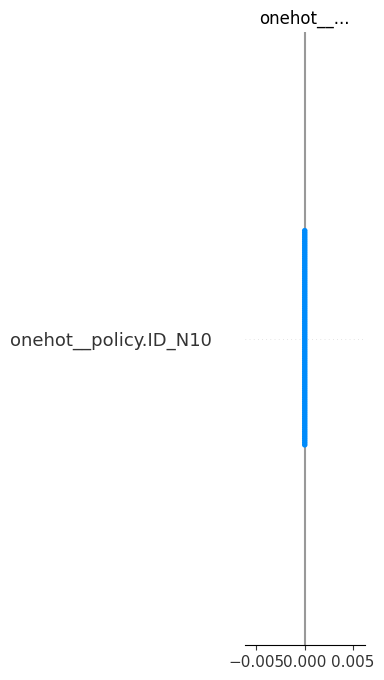

In [ ]:
import shap
predict_nn = lambda x: nn_model.predict(x)

# Selecting background samples
background = X_train_scaled_num[np.random.choice(X_train_scaled_num.shape[0], 100, replace=False)]

# Creating the KernelExplainer with the model's prediction function and background data
explainer = shap.KernelExplainer(predict_nn, background)

# Selecting a subset of test data for explanation
X_test_sample_num = X_test_scaled_num[:100]

# Computing SHAP values
shap_values = explainer.shap_values(X_test_sample_num, nsamples=100)

# Creating a new RNG object
rng = np.random.default_rng(seed=23)

# Pass this RNG explicitly to SHAP (if applicable)
shap.summary_plot(shap_values, features=X_test_sample_num, feature_names=feature_names, rng=rng)


The SHAP model explains how each feature influences your quote. For example, a high 'risk premium' or 'face amount' might increase the predicted quote, while other features like age or unemployment rate could decrease it.

The SHAP summary plot shows, across many sample quotes, which features are most influential overall. For instance in our case, the "onehot_policy.ID_N10' is at the top with positive SHAP values and will drive the quote higher. Conversely, features with negative SHAP values reduce the quote prediction.

# BIAS for the numerical problem

In this section we shall define a variable called "risk_category" that takes values High or Low if variable "proportion_risk_premium" is higher or lower than the treshold = 0.0002 = 0.02%.

Similarly, we shall define the variable "risk_category_pred" that does the same but on the basis of the values predicted by the Neural Network model.

We shall also count the number of High and Low values for Females and Males for these two variables.

In [ ]:
# Threshold = 0.0002 = 0.02%
threshold = 0.0002

df_num['risk_category'] = np.where(df_num['proportion_risk_premium'] > threshold, 'High', 'Low')
predicted_proportions = nn_model.predict(X_test_scaled_num).flatten()

# Creating 'risk_category_pred' based on predicted values
df_num.loc[df_num.index[:len(predicted_proportions)], 'risk_category_pred'] = np.where(
    predicted_proportions > threshold, 'High', 'Low')

# Counting the number of High/Low for Females and Males for true categories
counts_true = df_num.groupby(['gender', 'risk_category']).size().unstack(fill_value=0)

# Counting the number of High/Low for Females and Males for predicted categories
counts_pred = df_num.groupby(['gender', 'risk_category_pred']).size().unstack(fill_value=0)

# Displaying the counts
print("Counts for true risk categories:")
print(counts_true)

print("\nCounts for predicted risk categories:")
print(counts_pred)

172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Counts for true risk categories:
risk_category  High   Low
gender                   
Female         6994  1451
Male           9647  3829

Counts for predicted risk categories:
risk_category_pred  High
gender                  
Female              1876
Male                3605


The true risk labels show that approximately 83% of females (6,994 out of 8,445) and 72% of males (9,647 out of 13,476) are categorized as high risk. However, the model's predictions significantly underrepresent these high-risk groups, with only 1,876 females and 3,605 males predicted as high risk, way less than the actual counts.

This indicates that the model is conservative in assigning high risk, especially for females, and tends to underestimate the number of individuals truly at high risk.

Now we shall use the confusion_matrix to compare real and predicted values by counting: False positives, False negatives, Trues positives, True negatives.

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df_num['risk_category'], df_num['risk_category_pred'], labels=['High', 'Low'])

# Extracting the counts
TP = cm[0, 0]  # True Positives: predicted 'High' and actually 'High'
FN = cm[0, 1]  # False Negatives: predicted 'Low' but actually 'High'
FP = cm[1, 0]  # False Positives: predicted 'High' but actually 'Low'
TN = cm[1, 1]  # True Negatives: predicted 'Low' and actually 'Low'

# Printing results
print(f"Confusion Matrix:\n{cm}\n")
print(f"True Positives (High correctly predicted): {TP}")
print(f"False Negatives (High but predicted Low): {FN}")
print(f"False Positives (Low but predicted High): {FP}")
print(f"True Negatives (Low correctly predicted): {TN}")


## Metrics to detect possible bias on predicted values
In this section we investigate possible bias on the basis of the metrics:


*   Demographic Parity (no bias range: -0.1, 0.1)
*   Equal Opportunity (no bias range: -0.1, 0.1)
*   Average Odds (no bias range: -0.1, 0.1)
*   Disparate Impact (no bias range: 0.8, 1.25)
*   Theil Index (no bias range: 0, 0.15)

In [ ]:
# Calculating positive outcome rates per group
groups = ['gender']

results = []

for group in groups:
    for outcome in ['risk_category', 'risk_category_pred']:
        group_rates = df_num.groupby(group)[outcome].value_counts(normalize=True).unstack()
        results.append({
            'group': group,
            'outcome': outcome,
            'rates': group_rates
        })

# Computing metrics
def demographic_parity_diff(rates_group1, rates_group2):
    return abs(rates_group1 - rates_group2).max()

def equal_opportunity_diff(tpr_group1, tpr_group2):
    return abs(tpr_group1 - tpr_group2).max()

def average_odds_diff(tpr1, fpr1, tpr2, fpr2):
    return 0.5 * (abs(tpr1 - tpr2) + abs(fpr1 - fpr2))

def disparate_impact_ratio(rate_group1, rate_group2):
    return rate_group1 / rate_group2 if rate_group2 != 0 else np.inf

def theil_index(rates):
    rates = np.array(rates)
    rates = rates / rates.sum()
    return np.sum(rates * np.log(rates / rates.mean()))

# Calculating and comparing metrics between 2 groups
group1_rates = results[0]['rates']['High']
group2_rates = results[1]['rates']['High']

dp_diff = demographic_parity_diff(group1_rates, group2_rates)

print(f"Demographic Parity Difference: {dp_diff:.3f}")


Demographic Parity Difference: 0.284


What does this number mean?
The value 0.284 (or approximately 28.4%) reflects the maximum absolute difference in positive outcome rates between groups.
In your specific calculation, it compares the rate at which each group receives a positive label ('High') in your dataset.
Interpreting the value:
Close to 0: Perfect fairness — the positive outcome rate is nearly identical across groups.
Values near 1: Highly disparate — one group has a much higher or lower positive rate than the other.
Your value (0.284): Indicates a moderate disparity—about a 28.4% difference in positive rates between the groups.

## Bias mitigation
Here we proceed with:

*   Preprocessing bias mitigation: using the Reweighing method;
*   In-processing bias mitigation:  using the Meta Fair Classifier method;
*   Postprocessing bias mitigation: using the Reject option classification.

In [ ]:
# Preprocessing: Reweighing method

# Converting our dataset into AIF360 format
dataset = BinaryLabelDataset(df=df, label_names=['risk_category'], protected_attribute_names=['gender'])

# Applying Reweighing
RW = Reweighing()
dataset_transformed = RW.fit_transform(dataset)

# Using the sample weights in training
sample_weights = dataset_transformed.instance_weights

# Now train your classifier with sample_weights
clf_best = RandomForestClassifier(n_estimators=10, class_weight=None, random_state=23)
clf_best.fit(X_train_num, y_train_num, sample_weight=sample_weights)


In [ ]:
# In-processing: Meta Fair Classifier method
#dataset = BinaryLabelDataset(df=df, label_names=['risk_category'], protected_attribute_names=['gender'])

# Initializing MetaFairClassifier
mfc = MetaFairClassifier()

# Training the dataset
mfc.fit(dataset)

# Getting predictions
pred_dataset = mfc.predict(dataset)

# Converting predictions back to our data format
pred_labels = pred_dataset.labels


In [ ]:
# Post-Processing: Reject option classification

dataset_pred = dataset.copy()
dataset_pred.labels = y_pred

# Initialize Reject Option Classification
roc = RejectOptionClassification(
    unprivileged_groups=[{'gender': 0}],
    privileged_groups=[{'gender': 1}],
    low_class_thresh=0.3,
    high_class_thresh=0.7,
    num_class_thresh=10,
    num_ROC_margin=10
)

# Fitting and transforming
dataset_roc = roc.fit_transform(dataset, dataset_pred)

# Getting the final labels
y_final = dataset_roc.labels

# Preparing the predicted dataset
dataset_pred = dataset.copy()
dataset_pred.labels = clf_best.predict(X_test_cat)

# Initializing RejectOptionClassification
ROC = RejectOptionClassification(unprivileged_groups=[{'gender': 0}], privileged_groups=[{'gender': 1}])

# Fitting and adjusting predictions
roc_pred = ROC.fit_transform(dataset, dataset_pred)

# Final predictions after postprocessing
final_labels = roc_pred.labels


Using Reweighing for pre-processing offers a quick and effective way to reduce bias with minimal computational cost, MetaFair in-processing balances fairness and accuracy during training but requires some tuning and Reject Option postprocessing provides a practical, fast method to enforce fairness constraints on predictions in large datasets.

However, Reweighing only adjusts sample weights without directly altering the data distribution (hence not fully eliminating bias in highly imbalanced or complex datasets), MetaFair may slightly reduce overall model performance due to its careful hyperparameter tuning requirement and Reject Option postprocessing can lead to significant prediction rejections, lowering coverage and decision efficiency in addition to requiring careful threshold tuning to balance fairness gains with practical usability.


In [53]:
import requests
import nbformat

# Your raw GitHub URL
url = 'https://raw.githubusercontent.com/Regis0323/Module-3-assignment/refs/heads/main/Rurangwa_Module_3_Assignment_.ipynb'

# Fetch the notebook content
response = requests.get(url)
response.raise_for_status()

# Load the notebook content, assuming version 4 (most common)
nb = nbformat.reads(response.text, as_version=4)

# Save the notebook locally
with open('Downloaded_Notebook.ipynb', 'w') as f:
    nbformat.write(nb, f)
